In [1]:
import os
import math
import numpy as np
import tensorflow as tf
import cv2

slim = tf.contrib.slim

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as mpcm

In [3]:
colors_tableau = [(255, 255, 255), (31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

In [4]:
isess = tf.InteractiveSession()

# Drawing and plotting routines.

In [5]:
def bboxes_draw_on_img(img, scores, bboxes, colors, thickness=2, show_text=True):
    shape = img.shape
    for i in range(bboxes.shape[0]):
        bbox = bboxes[i]
        color = colors[i % len(colors)]
        # Draw bounding box...
        p1 = (int(bbox[0] * shape[0]), int(bbox[1] * shape[1]))
        p2 = (int(bbox[2] * shape[0]), int(bbox[3] * shape[1]))
        cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
        # Draw text...
        if show_text:
            s = '%s: %.3f' % ('Car', scores[i])
            p1 = (p1[0]-5, p1[1])
            cv2.putText(img, s, p1[::-1], cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
        
def plot_image(img, title='', figsize=(24, 9)):
    f, axes = plt.subplots(1, 1, figsize=figsize)
    f.tight_layout()
    axes.imshow(img)
    axes.set_title(title, fontsize=25)

# SSD TensorFlow Network

Build up the convolutional network and load the checkpoint.

In [6]:
from nets import ssd_vgg_300
from nets import ssd_common
from preprocessing import ssd_vgg_preprocessing

# ckpt_filename = '/media/paul/DataExt4/PascalVOC/training/ckpts/SSD_300x300_ft/ssd_300_vgg.ckpt'
# ckpt_filename = '../logs/ssd_300_kitti_3/model.ckpt-48978'
ckpt_filename = './checkpoints/model.ckpt-5181'
ckpt_filename = './checkpoints/ssd_model.ckpt'

In [7]:
# Input placeholder.
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, (None, None), resize=ssd_vgg_preprocessing.Resize.NONE)
image_4d = tf.expand_dims(image_pre, 0)

# Network parameters.
params = ssd_vgg_300.SSDNet.default_params
params = params._replace(num_classes=8)

# SSD network construction.
reuse = True if 'ssd' in locals() else None
ssd = ssd_vgg_300.SSDNet(params)
with slim.arg_scope(ssd.arg_scope(weight_decay=0.0005)):
    predictions, localisations, logits, end_points = ssd.net(image_4d, is_training=False, reuse=reuse)

In [8]:
# Initialize variables.
init_op = tf.global_variables_initializer()
isess.run(init_op)

# Restore SSD model.
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)
# Save back model to clean the checkpoint?
save_clean = False
if save_clean:
    ckpt_filename_save = './checkpoints/ssd_model.ckpt'
    saver.save(isess, ckpt_filename_save, write_meta_graph=True, write_state=True)

# Pipeline example

Presenting the different steps of the vehicle detection pipeline.

In [9]:
# Main processing routine.
def ssd_process_image(img, select_threshold=0.5):
    """Process an image through SSD network.
    
    Arguments:
      img: Numpy array containing an image.
      select_threshold
      nms_threshold
    """
    # Resize image to height 300.
    factor = 300. / float(img.shape[0])
    img = cv2.resize(img, (0,0), fx=factor, fy=factor) 
    # Run SSD network and get class prediction and localization.
    rpredictions, rlocalisations = isess.run([predictions, localisations], feed_dict={img_input: img})
    
    # Get anchor boxes for this image shape.
    ssd.update_feature_shapes(rpredictions)
    anchors = ssd.anchors(img.shape, dtype=np.float32)
    
    # Compute classes and bboxes from the net outputs: decode SSD output.
    rclasses, rscores, rbboxes, rlayers, ridxes = ssd_common.ssd_bboxes_select(
            rpredictions, rlocalisations, anchors,
            threshold=select_threshold, img_shape=img.shape, num_classes=ssd.params.num_classes, decode=True)
    
#     rbboxes = ssd_common.bboxes_clip(rbbox_img, rbboxes)
    # Remove other classes than cars.
    idxes = (rclasses == 1)
    rclasses = rclasses[idxes]
    rscores = rscores[idxes]
    rbboxes = rbboxes[idxes]
    # Sort boxes by score.
    rclasses, rscores, rbboxes = ssd_common.bboxes_sort(rclasses, rscores, rbboxes, 
                                                        top_k=400, priority_inside=True, margin=0.0)
#     rclasses, rscores, rbboxes = ssd_common.bboxes_nms(rclasses, rscores, rbboxes, threshold=nms_threshold)
    return rclasses, rscores, rbboxes

Shape: (720, 1280, 3)


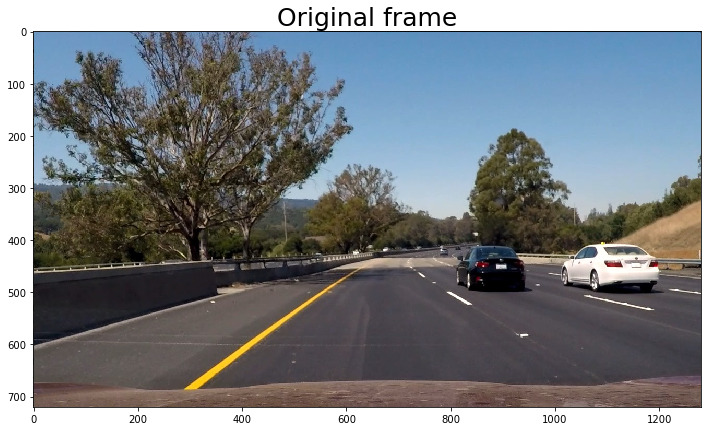

In [10]:
# Load a sample image.
path = 'test_images/'
image_names = sorted(os.listdir(path))
img = mpimg.imread(path + image_names[5])

print('Shape:', img.shape)
plot_image(img, 'Original frame', (10, 10))

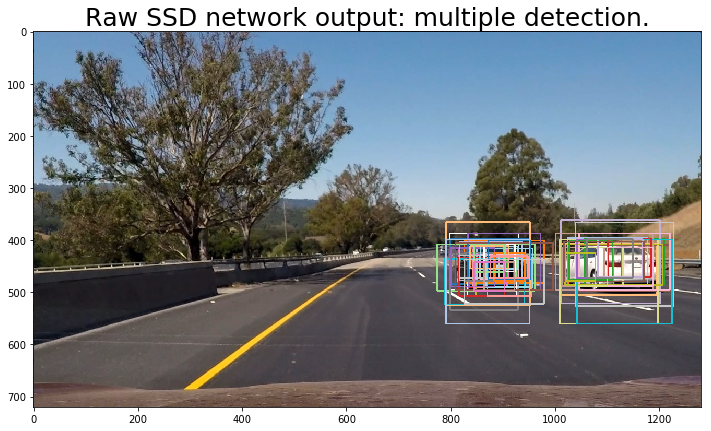

In [11]:
# Process image
rclasses, rscores, rbboxes = ssd_process_image(img, select_threshold=0.6)
# Draw bboxes
img_bboxes = np.copy(img)
bboxes_draw_on_img(img_bboxes, rscores, rbboxes, colors_tableau, thickness=2, show_text=False)

plot_image(img_bboxes, 'Raw SSD network output: multiple detection.', (10, 10))

In [12]:
def bboxes_nms_jaccard(classes, scores, bboxes, threshold=0.45):
    """Apply non-maximum selection to bounding boxes using Jaccard score.
    """
    keep_bboxes = np.ones(scores.shape, dtype=np.bool)
    for i in range(scores.size-1):
        if keep_bboxes[i]:
            # Computer overlap with bboxes which are following.
            overlap = ssd_common.bboxes_jaccard(bboxes[i], bboxes[(i+1):])
            # Overlap threshold for keeping + checking part of the same class
            keep_overlap = np.logical_or(overlap < threshold, classes[(i+1):] != classes[i])
            keep_bboxes[(i+1):] = np.logical_and(keep_bboxes[(i+1):], keep_overlap)

    idxes = np.where(keep_bboxes)
    return classes[idxes], scores[idxes], bboxes[idxes]

def bboxes_nms_intersection(classes, scores, bboxes, threshold=0.45):
    """Apply non-maximum selection to bounding boxes using intersection score.
    """
    keep_bboxes = np.ones(scores.shape, dtype=np.bool)
    for i in range(scores.size-1):
        if keep_bboxes[i]:
            # Computer overlap with bboxes which are following.
            overlap = ssd_common.bboxes_intersection(bboxes[i], bboxes[(i+1):])
            # Overlap threshold for keeping + checking part of the same class
            keep_overlap = np.logical_or(overlap < threshold, classes[(i+1):] != classes[i])
            keep_bboxes[(i+1):] = np.logical_and(keep_bboxes[(i+1):], keep_overlap)

    idxes = np.where(keep_bboxes)
    return classes[idxes], scores[idxes], bboxes[idxes]

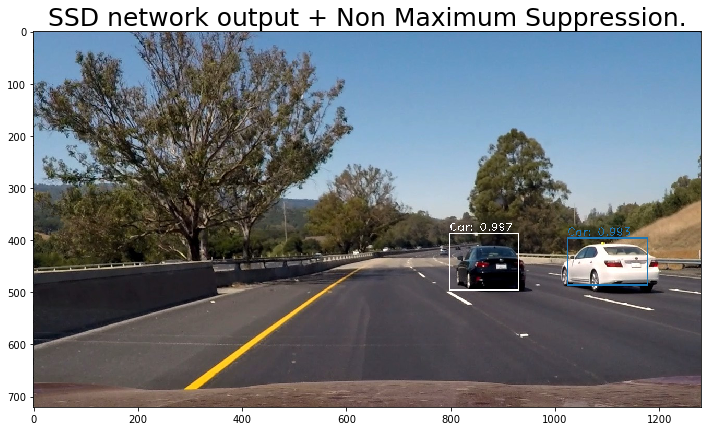

In [31]:
# Apply Non-Maximum-Selection
nms_threshold = 0.3
rclasses_nms, rscores_nms, rbboxes_nms = bboxes_nms_intersection(rclasses, rscores, rbboxes, threshold=nms_threshold)

# Draw bboxes
img_bboxes = np.copy(img)
bboxes_draw_on_img(img_bboxes, rscores_nms, rbboxes_nms, colors_tableau, thickness=2)

plot_image(img_bboxes, 'SSD network output + Non Maximum Suppression.', (10, 10))

# Vehicle detection: images

# Vehicle detection: videos

In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2

In [15]:
# Pre-compute anchors based on video resolution.
video_shape = (720, 1280, 3)
anchors = ssd.anchors(video_shape, dtype=np.float32)

In [20]:
def ssd_process_frame(img, select_threshold=0.5, nms_threshold=0.3):
    """Process a video frame through SSD network.
    
    Arguments:
      img: Numpy array containing an image.
      select_threshold
      nms_threshold
    """
    # Resize image to height 300.
    factor = 300. / float(img.shape[0])
    img = cv2.resize(img, (0,0), fx=factor, fy=factor) 
    # Run SSD network and get class prediction and localization.
    rpredictions, rlocalisations = isess.run([predictions, localisations], feed_dict={img_input: img})
    
    # Get anchor boxes for this image shape.
    ssd.update_feature_shapes(rpredictions)
    anchors = ssd.anchors(img.shape, dtype=np.float32)
    
    # Compute classes and bboxes from the net outputs: decode SSD output.
    rclasses, rscores, rbboxes, rlayers, ridxes = ssd_common.ssd_bboxes_select(
            rpredictions, rlocalisations, anchors,
            threshold=select_threshold, img_shape=img.shape, num_classes=ssd.params.num_classes, decode=True)
    
    # Remove other classes than cars.
    idxes = (rclasses == 1)
    rclasses = rclasses[idxes]
    rscores = rscores[idxes]
    rbboxes = rbboxes[idxes]
    # Sort boxes by score.
    rclasses, rscores, rbboxes = ssd_common.bboxes_sort(rclasses, rscores, rbboxes, 
                                                        top_k=400, priority_inside=True, margin=0.0)
    # Apply NMS.
    rclasses, rscores, rbboxes = bboxes_nms_intersection(rclasses, rscores, rbboxes, 
                                                         threshold=nms_threshold)
    # Draw bboxes
    bboxes_draw_on_img(img, rscores, rbboxes, colors_tableau, thickness=2)
    return img

In [28]:
# process_frame.lanes_past = []
# process_frame.frame = 0
# process_frame.frames = [0, 0]
# process_frame.frames = [0, np.inf]

# Selection parameters.
select_threshold=0.8
nms_threshold=0.2

white_output = 'test_video_cars.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(lambda x: ssd_process_frame(x, select_threshold, nms_threshold))
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_video_cars.mp4
[MoviePy] Writing video test_video_cars.mp4



 97%|█████████▋| 38/39 [00:01<00:00, 21.10it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_cars.mp4 

CPU times: user 20.7 s, sys: 772 ms, total: 21.5 s
Wall time: 2.18 s


In [29]:
white_output = 'project_video_cars.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(lambda x: ssd_process_frame(x, select_threshold, nms_threshold))
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_cars.mp4
[MoviePy] Writing video project_video_cars.mp4



100%|█████████▉| 1260/1261 [01:06<00:00, 18.90it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_cars.mp4 

CPU times: user 10min 51s, sys: 24.3 s, total: 11min 15s
Wall time: 1min 7s


In [30]:
white_output = 'challenge_video_cars.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(lambda x: ssd_process_frame(x, select_threshold, nms_threshold))
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video challenge_video_cars.mp4
[MoviePy] Writing video challenge_video_cars.mp4



100%|██████████| 485/485 [00:26<00:00, 20.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_cars.mp4 

CPU times: user 4min 23s, sys: 9.64 s, total: 4min 32s
Wall time: 26.7 s
